In [ ]:
### PLACE ANY PIP INSTALLS NEEDED HERE

# Imports

In [21]:
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.tokenization_utils_base import BatchEncoding
import torch
import logging
import matplotlib.pyplot as plt
import string
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from bert_score import score
from datasets import load_dataset, load_metric
from tqdm.auto import tqdm
import json
from peft import AutoPeftModelForCausalLM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(level=logging.INFO)

# Metrics and Text Generation Helper Functions

In [22]:
def calculate_bleu(reference, candidate):
    reference_tokens = [reference.split()]
    candidate_tokens = candidate.split()
    smoothie = SmoothingFunction().method1  # You can experiment with different smoothing methods
    return sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=smoothie)

def calculate_rouge_l(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    return scorer.score(reference, candidate)['rougeL'].fmeasure

def calculate_bert_score(reference, candidate):
    *_, bert_scores = score([candidate], [reference], lang='en', return_hash=False)
    return bert_scores.mean().item()

def evaluate_text_quality(reference, candidate):
    return {
        'BLEU': calculate_bleu(reference, candidate),
        'ROUGE-L': calculate_rouge_l(reference, candidate),
        'BERTScore': calculate_bert_score(reference, candidate)
    }

def calculate_scores(test_dataset, generated_responses):
    """
        Return the scores based on some generated text and the ground truth
    """
    scores = {'BLEU': 0, 'ROUGE-L': 0, 'BERTScore': 0}

    num_samples = len(test_dataset)

    for i, test_data in tqdm(enumerate(test_dataset)):
        evaluation_results = evaluate_text_quality(test_data['output'], generated_responses[i]['output'])
        for key in scores:
            scores[key] += evaluation_results[key]

    # Average the scores
    for key in scores:
        scores[key] /= num_samples

    return scores

def generate_text(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    prompt: str,
    max_num_tokens: int = 25,
    top_k: int = 5,
    layer: int = 8,
    temperature: float = 1.0,
    stop_token_ids: list = [],
    stop_words: list = [],
    eos_weight: float = 2.0,
    enable_logging: bool = False
) -> str:
    """
    Generate text using a language model.

    Args:
        model (model): The language model.
        tokenizer (model): The tokenizer corresponding to the model.
        prompt (str): The initial text to start generation from.
        num_tokens (int, optional): The number of tokens to generate. Defaults to 5.
        top_k (int, optional): The number of top tokens to consider for sampling. Defaults to 5.
        layer (int, optional): The layer of the model to use for generation. Defaults to 8.
        temperature (float, optional): The temperature for softmax. Defaults to 1.0.
        stop_token_ids (list, optional): List of token ids that will end generation if sampled. Defaults to [].
        stop_words (list, optional): List of words that will end generation if sampled. Defaults to [].
        eos_weight (float, optional): The weight to assign to the EOS token. Defaults to 2.0.
        enable_logging (bool, optional): Enable logging for debugging. Defaults to False.

    Returns:
        str: The generated text.
    """
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)
    print(layer)
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs.to(device)

    # Get the EOS token ID
    eos_token_id = tokenizer.eos_token_id
    stop_token_ids.append(eos_token_id)
    output_tokens = []

    # Generate num_tokens tokens
    for _ in range(max_num_tokens):
        # Forward pass through the model
        outputs = model(**inputs)

        # Get the output of the specified layer
        layer_output = outputs.hidden_states[layer]

        # Pass the output through the final linear layer
        logits = model.lm_head(layer_output)

        # Apply softmax to get probabilities
        probabilities = F.softmax(logits / temperature, dim=-1)

        # Increase the weight of the EOS token
        probabilities[0, -1, eos_token_id] *= eos_weight

        # Get the probabilities of the top k tokens
        top_k_probabilities, top_k_indices = torch.topk(probabilities[0, -1], top_k)

        # Normalize the top k probabilities
        top_k_probabilities /= torch.sum(top_k_probabilities)

        # Sample from the top k probability distribution
        sampled_token_id = top_k_indices[torch.multinomial(top_k_probabilities, 1)].item()
        output_tokens.append(sampled_token_id)

        # Decode the token id back into text
        sampled_token_text = tokenizer.decode([sampled_token_id])
        sampled_token = {'input_ids': torch.tensor([[1, sampled_token_id]]), 'attention_mask': torch.tensor([[1, 1]])}

        # If the sampled token is a stop token or stop word, return the generated text
        if sampled_token_id in stop_token_ids or sampled_token_text in stop_words:
            generated_text = tokenizer.decode(inputs['input_ids'][0])
            pure_output = tokenizer.decode(output_tokens)
            return {'text':generated_text,'output':pure_output,'prompt':prompt}

        combined_input_ids = torch.cat((inputs['input_ids'].detach().cpu(), sampled_token['input_ids'][:,1:]), dim=-1)
        combined_attention_mask = torch.cat((inputs['attention_mask'].detach().cpu(), sampled_token['attention_mask'][:,1:]), dim=-1)

        inputs = BatchEncoding({'input_ids': combined_input_ids, 'attention_mask': combined_attention_mask}).to(device)

        # Log the token and top k tokens if logging is enabled
        if enable_logging:
            print(f'Token: {sampled_token_text}')
            print('      -- Top tokens --')
            for i in range(top_k):
                token = tokenizer.decode([top_k_indices[i].item()])
                probability = top_k_probabilities[i].item()
                print(f'   {token}: {probability}')

            print()
    generated_text = tokenizer.decode(inputs['input_ids'][0])
    pure_output = tokenizer.decode(output_tokens)
    return {'text':generated_text,'output':pure_output,'prompt':prompt}

def format_prompt(instruction, input = '', output = ''):
    return 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n'+instruction+'\n\n### Input:\n'+input+'\n\n### Response:\n'+output

def generate_responses(model, tokenizer, dataset,
    max_num_tokens: int = 25,
    top_k: int = 5,
    layer: int = 8,
    temperature: float = 1.0,
    stop_token_ids: list = [],
    stop_words: list = [],
    eos_weight: float = 2.0,
    enable_logging: bool = False):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    outputs = []

    for prompt in dataset:
        outputs.append(generate_text(model, tokenizer, format_prompt(prompt['instruction'], prompt['input']), max_num_tokens, top_k, layer, temperature, stop_token_ids, stop_words, eos_weight, enable_logging))

    return outputs

# Probabilities Example

We will first take a look at the probabilities of the model output in detail. Below we will initialize the Llama 3 8B parameter model and then examine how the probabilities of the tokens change between the layers.

In [ ]:
# Load the model with output_hidden_states set to True
model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B", output_hidden_states=True).to(device)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

print(model)

In [ ]:
prompt = "We are"
# print(get_top_n_tokens(model, tokenizer, prompt, n=10, layer=-1))
output = generate_text(model, tokenizer, prompt, max_num_tokens = 20, layer = 32, temperature = 0.2, stop_words=['\n'], enable_logging=True)


# Models and Dataset

Below you will notice there are both normal and finetuned versions of the models. Make sure that they match in order if using Unsloth weights because we will need the tokenizer from the original model.

For example: [vanilla_model1, vanilla_model2] and [finetuned_model1, finetuned_model2]

The layers are the layers to evaluate.

The dataset is the Alpaca finetuning dataset. You can use a different dataset if desired, however, make sure to change the format_prompt function so that the LLMs are correctly queried.

In [24]:
normal_models = ['unsloth/mistral-7b-bnb-4bit','microsoft/phi-2','meta-llama/Llama-2-7b-chat-hf', "meta-llama/Meta-Llama-3-8B"]
lora_models = ['lora_mistral', 'phi2-2b-alpaca','lora_llama7b_alpaca_ft']
layers = [8, 16, 24, 32]

# Load your dataset
dataset_name = "tatsu-lab/alpaca"  # Replace with your dataset
dataset = load_dataset(dataset_name)
dataset = dataset['train']

# Split the dataset into train and test with a fixed seed
train_test_split = dataset.train_test_split(test_size=0.0005, seed=42)
# train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Evaluation Loop

Below the normal models and my lora finetuned models are evaluated. If you wish to not evaluate the normal models, then simply comment out or delete the normal_models loop. Same story for the fine-tuned models if you don't have them.

This will output a results array which contains dictionaries that contain the average evaluation metrics of each of the models on the testing dataset. It will also save the configuration parameters used in training such as the layer number, temperature, and the top_k.

In [ ]:
results = []
for each_model in normal_models:
    if each_model == "meta-llama/Meta-Llama-3-8B":
        for layer in layers:
            # Load the model and tokenizer
            model = AutoModelForCausalLM.from_pretrained(each_model, output_hidden_states=True)
            tokenizer = AutoTokenizer.from_pretrained(each_model)

            config = {'top_k': 5, 'temperature': 0.1, 'layer': layer, 'max_num_tokens': 8}

            outputs = generate_responses(model, tokenizer, test_dataset, top_k = config['top_k'],temperature = config['temperature'], max_num_tokens=config['max_num_tokens'], layer = config['layer'], enable_logging=True)
            scores_model = calculate_scores(test_dataset=test_dataset, generated_responses=outputs)

            results.append({'model':each_model,'results':scores_model, 'outputs':outputs, 'config':config})

for i, each_model in enumerate(lora_models):
    for layer in layers:
        # Load the model and tokenizer
        model = AutoPeftModelForCausalLM.from_pretrained(
            each_model, # YOUR MODEL YOU USED FOR TRAINING
            load_in_4bit = True,
            output_hidden_states=True
        )
        tokenizer = AutoTokenizer.from_pretrained(normal_models[i])

        config = {'top_k': 5, 'temperature': 0.1, 'layer': layer, 'max_num_tokens': 35}

        outputs = generate_responses(model, tokenizer, test_dataset, top_k = config['top_k'],temperature = config['temperature'], max_num_tokens=config['max_num_tokens'], layer = config['layer'], enable_logging=True)
        scores_model = calculate_scores(test_dataset=test_dataset, generated_responses=outputs)

        results.append({'model':each_model,'results':scores_model, 'outputs':outputs, 'config':config})


with open(f'results.json', 'w+') as f:
    json.dump(results, f)
# print(outputs)

In [ ]:
# Open the JSON file
with open('results.json', 'r') as file:
    data = json.load(file)

# Now the variable "data" holds the data from the JSON file
print(data)

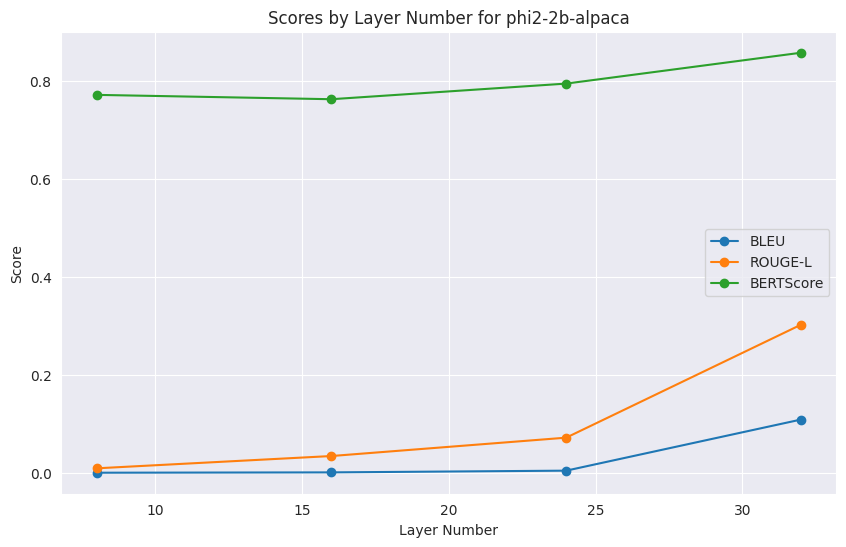

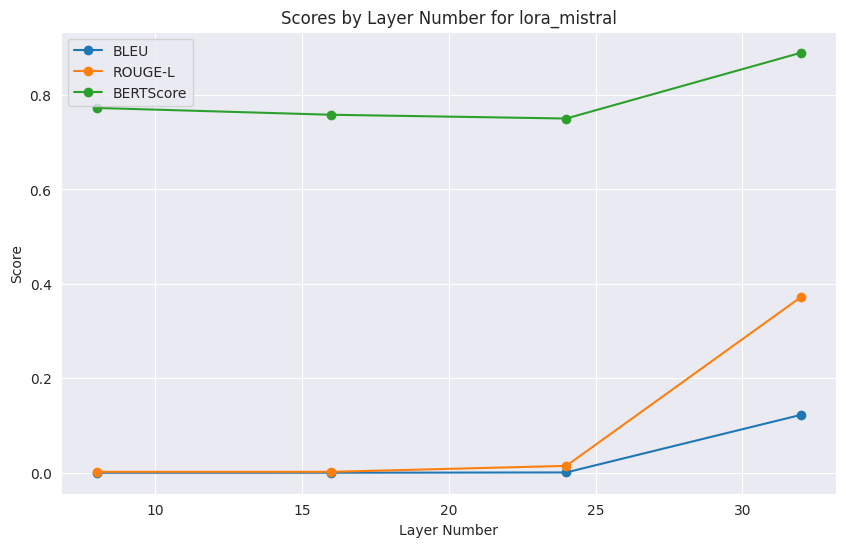

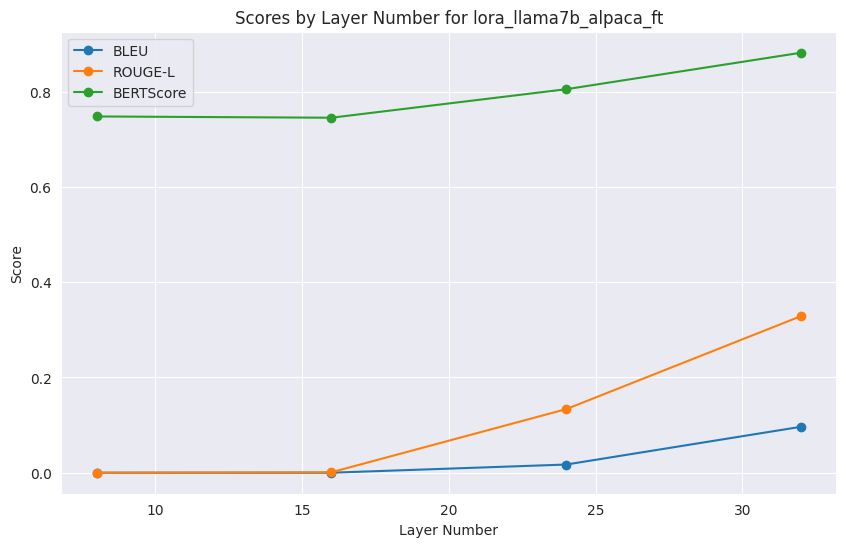

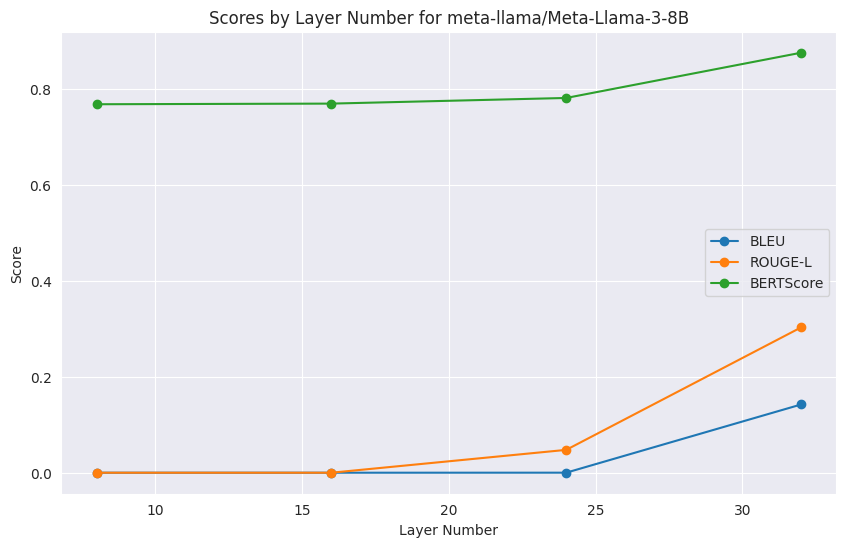

In [27]:
# Get unique models
models = set(d['model'] for d in data)

for model in models:
    # Filter data for the current model
    model_data = [d for d in data if d['model'] == model]

    layers = [d['config']['layer'] for d in model_data]
    bleu_scores = [d['results']['BLEU'] for d in model_data]
    rouge_scores = [d['results']['ROUGE-L'] for d in model_data]
    bert_scores = [d['results']['BERTScore'] for d in model_data]

    plt.figure(figsize=(10, 6))

    plt.plot(layers, bleu_scores, marker='o', label='BLEU')
    plt.plot(layers, rouge_scores, marker='o', label='ROUGE-L')
    plt.plot(layers, bert_scores, marker='o', label='BERTScore')

    plt.xlabel('Layer Number')
    plt.ylabel('Score')
    plt.title(f'Scores by Layer Number for {model}')
    plt.legend()

    plt.show()